# TODO
For a visual model of your choice:
- Perform linear read-outs at different levels of the model hierarchy to investigate whether sensory representations become increasingly more disentangled at the deepest layers **[2 points]**. 
- Analyze the internal representations developed by the model by exploiting hierarchical clustering and feature 
visualization (e.g., receptive fields) analysis **[2 points]**. 
- Visualize confusion matrices and psychometric curves to investigate the kind of errors made by the model; 
psychometric curves can be created by adding an increasing amount of noise to the test data **[2 points]**. 
- Explore the model response to adversarial attacks (and potential defenses) and/or the capability of few-shot 
learning **[2 points]**. 
- Clearly explain the details of your implementation (e.g., model architecture, training and testing methodology), 
motivating your choices and critically discussing the results with respect to the topics covered during the course 
**[2 points]**. 
 
Optional: Try weight initialization

# An exploration of visual concept learning by example of a variational autoencoder (VAE)
Practical part to the exam in Cognition and Computation, University of Padova, 2025-01-12.
## Author
Frederik Dammeier

`frederik.dammeier@studenti.unipd.it`

2169606

# Dataset

We select as the dataset for the folloing experiments the **Fruits and Vegetables Image Recognition Dataset** publicly available on Kaggle: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

This dataset contains **36 classes** of different fruits and vegetables distributed across a train-val-test split. The base images are of varying sizes and too big for the following experiments, so we resize them ahead of the modeling pipeline.


# Download data
For this series of experiments, we use a version of the original dataset that is resized and squared to 64*64 images. It is provided alongside the code for the model on the project Github: https://github.com/frederikdammeier/unipd-cognition-computation

In [13]:
%%capture
!mkdir data
!wget -O data/fruits-vegetables-resized64.zip "https://github.com/frederikdammeier/unipd-cognition-computation/blob/main/data/fruits-vegetables-resized64.zip?raw=true"
!unzip data/fruits-vegetables-resized64.zip -d data/

mkdir: data: File exists
--2026-01-08 10:27:33--  https://github.com/frederikdammeier/unipd-cognition-computation/blob/main/data/fruits-vegetables-resized64.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/frederikdammeier/unipd-cognition-computation/raw/refs/heads/main/data/fruits-vegetables-resized64.zip [following]
--2026-01-08 10:27:33--  https://github.com/frederikdammeier/unipd-cognition-computation/raw/refs/heads/main/data/fruits-vegetables-resized64.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/frederikdammeier/unipd-cognition-computation/refs/heads/main/data/fruits-vegetables-resized64.zip [following]
--2026-01-08 10:27:33--  https://raw.githubusercontent.com/frederikdammeier/unipd-cognition-computation/refs/heads/main/

OSError: [Errno 5] Input/output error

# Additional code
We have externalized some Python classes and functions to seperate files that we download from the associated github repository.

In [10]:
def get_codefiles():
  files = ["src/data.py", "src/vision_vae.py", "train_vae.py"]
  repository_url = "https://raw.githubusercontent.com/frederikdammeier/unipd-cognition-computation/main/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [12]:
%%capture
get_codefiles()

# Dataset and DataLoader
We provide simple Pytorch Dataset and DataLoader classes to deal with the image dataset. Ahead of training, we can use it to display a batch of sample images from the dataset, and to calculate dataset statistics.


In [6]:
from src.data import ImageDataLoader

# Create a dataloader for the training set (equivalent for validation/test sets)
train_dl = ImageDataLoader.create_dataloader(
    "./data/resized64/versions/8/train", batch_size=4, shuffle=True, num_workers=4
)

train_ds = train_dl.dataset
print(f"Number of training samples: {len(train_ds)}")

Number of training samples: 2847


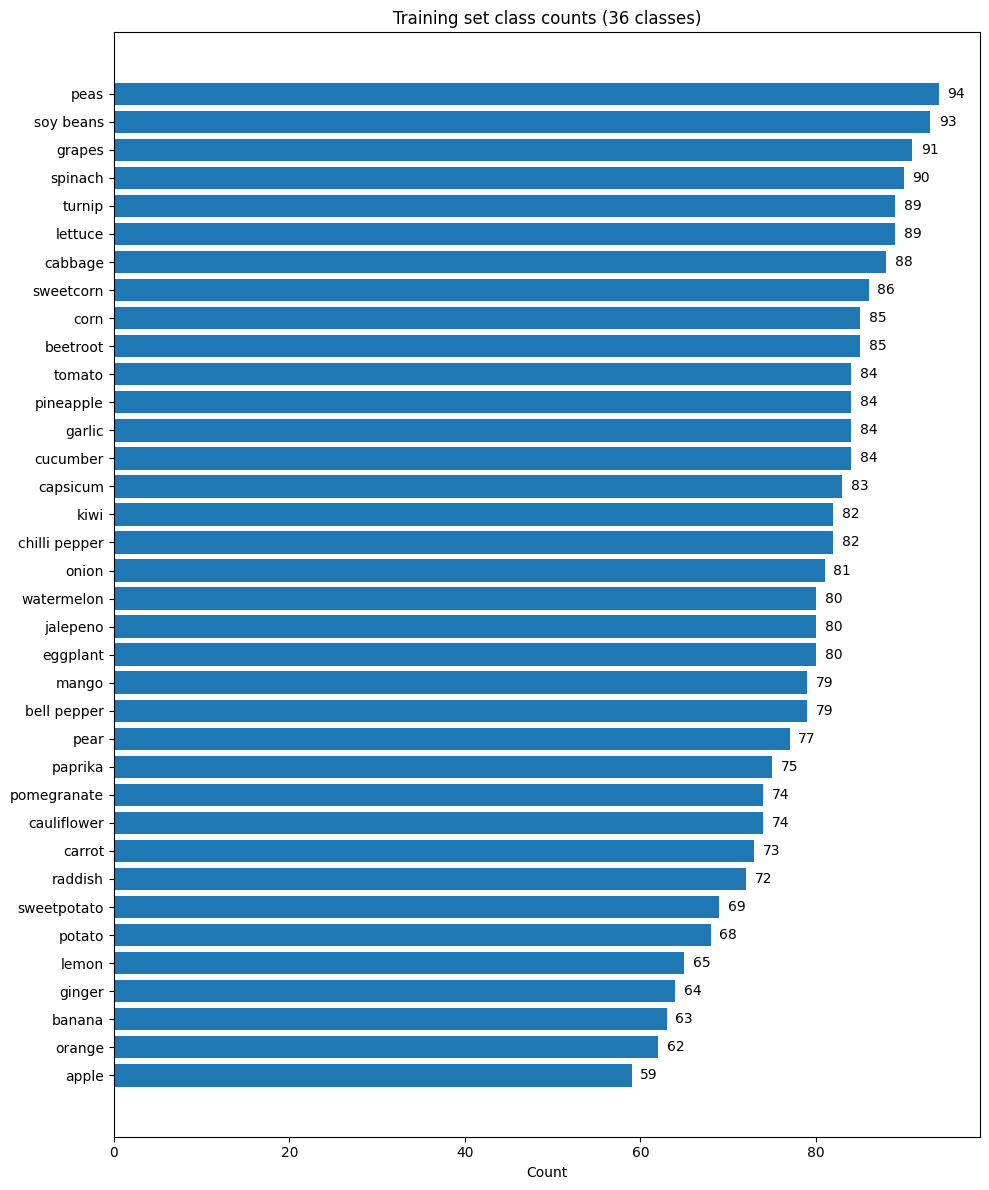

In [7]:
from collections import Counter
import numpy as np

# Class statistics
labels = train_ds.labels
idx_to_class = train_ds.idx_to_class

import matplotlib.pyplot as plt

counts = Counter(labels)
class_indices = sorted(idx_to_class.keys())
class_names = [idx_to_class[i] for i in class_indices]
class_counts = [counts.get(i, 0) for i in class_indices]

# sort by count (descending) for better readability
sorted_pairs = sorted(zip(class_counts, class_names), reverse=True)
counts_sorted, names_sorted = zip(*sorted_pairs)

plt.figure(figsize=(10, 12))
y_pos = np.arange(len(names_sorted))
plt.barh(y_pos, counts_sorted, color='tab:blue')
plt.yticks(y_pos, names_sorted)
plt.gca().invert_yaxis()  # largest on top
plt.xlabel('Count')
plt.title(f'Training set class counts ({len(counts)} classes)')
# annotate counts
max_count = max(counts_sorted) if counts_sorted else 0
for i, v in enumerate(counts_sorted):
    plt.text(v + max(1, max_count * 0.01), i, str(v), va='center')
plt.tight_layout()
plt.show()

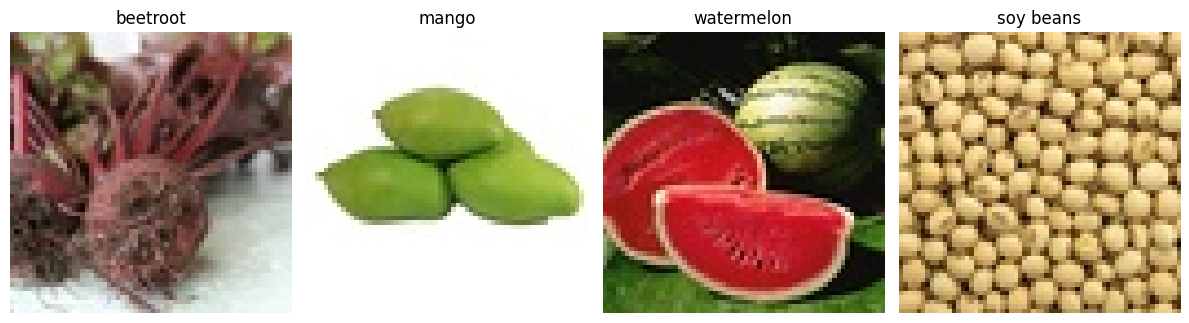

In [8]:
from torchvision.transforms import ToPILImage

# get one batch from the dataloader
batch = next(iter(train_dl))
imgs, targets = batch[0], batch[1]

plt.figure(figsize=(12, 4))
for i, img in enumerate(imgs):
    pil = ToPILImage()(img.cpu())
    plt.subplot(1, 4, i + 1)
    plt.imshow(pil)
    plt.axis('off')
    title = idx_to_class.get(int(targets[i]), '') if targets[i] is not None else ''
    plt.title(title)
plt.tight_layout()
plt.show()

# Model
We chose as our model of exploration a variational autoencoder (VAE). The VAE, first introduced by D.P. Kingma and M. Welling in 2013 is a computational framework for usupervised learning of data distributions. While deriving its name from traditional autoencoder networks that use a bottleneck within a deep neural network to learn a low-dimensional representation of the data, VAEs actually model the data distrubution directly which enables the generation of new (unseen) samples from the learnt data distribution once the model is trained. This places the VAE as a prominent example of the larger family of generative neural network architectures.

A thorough introduction to VAEs is out of scope of this work. Importantly, VAEs apply a variety of mathematical tricks to arrive at an estimation of the data probability distribution _Pr(X)_. One of these is the variational approximation of _Pr(X)_ by a lower-dimensional latent distribution _Pr(Z|X)_ which gives the VAE its name. Another is the use of the **ELBO**, the lower bound to the evidence (of the data), as the loss function during training, which can be phrased as dependent on both the encoder and decoder parameters. In its most practical and widely used from, `ELBO = reconstruction_error - variational_divergence`, the ELBO is easily integrated into the training pipeline and allows to put a weight on the factors. Usually, the variational divergence (Kullbach-Leibacher divergence between latent prior and posterior) is weighted by a factor of beta (beta-VAE, Higgings et al. 2017) which allows to emphasize the structure of the latent representation during training.

Higgings et al. and later authors show that under certain assumptions and parametrizations, VAEs are capable of disentangling features of the data-space in their latent representations.

## Architecture
We construct a simple vision VAE based on convolutional layers.

In [9]:
from src.vision_vae import VisionVAE

latent_dim = 64
beta = 1.0
beta_norm = beta / ((64 * 64 * 3) / latent_dim) # normalize beta based on input and latent size (empirical insight)

vae = VisionVAE(latent_dim=latent_dim, beta=beta_norm)

print(vae)

VisionVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=4096, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=4096, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=4096, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


We use four convolutional layers for the encoder and decoder respectively, employing stride to reduce the size of the feature map with each step. The resulting linear layer is of size 4096 and is used to learn the mean and log-variance of the Gaussian latent space posterior.

We use a classic implementation of the ELBO including beta:
```python 
# Reconstruction loss
recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')

# KL divergence loss
kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

# Total loss with beta weighting
loss = recon_loss + self.beta * kl_loss
```
The formulation of the KL-divergence ensures that the model is encouraged to map the data distribution to a Gaussian distribution with 0 mean and unit variance, thus encouraging disentangled features (no covariance).

## Training
We provide an externalized train script `train_vae.py` which will be imported into this notebook for documentation purposes. Besides the standard training parameters like batch size and learning rate, we implement the following particularities:

- Beta normalization. The input beta is normalized by input size (W*H*C) and latent_dim following literature insight (e.g. Higgings et al. 2017): `beta_norm = beta / ((64 * 64 * 3) / latent_dim)`
- Transforms. We apply random horizontal flipping as an augmentation strategy.
- Optimizer. We use a standard Adams optimizer.
- Logging. We use Weights and Biases (https://wandb.ai) to track our training runs. This is optional and will not be active unless logged in.

The choice of the dataset and model sizes is such that it can be conveniently trained on moderate hardware. On a MacBook Air M3, training of a single model for 50 epochs takes about 5 minutes.


In [1]:
from train_vae import train_vae

data_root = "./data/resized64/versions/8/train"
batch_size = 32
num_epochs = 50
learning_rate = 1e-3
latent_dim = 64
beta = 5.0 # we found the training to be quite robust to small changes in beta. Similar results are obtained for beta = 1.0.
num_workers = 0
use_wandb = False

train_vae(data_root=data_root,
          batch_size=batch_size,
          num_epochs=num_epochs,
          learning_rate=learning_rate,
          latent_dim=latent_dim,
          beta=beta,
          num_workers=num_workers,
          use_wandb=use_wandb)

Using device: cpu
Normalized beta: 0.026041666666666668
Loading data from ./data/resized64/versions/8/train
Loaded 2847 images
Created VisionVAE with latent_dim=64, beta=0.026041666666666668

Starting training for 50 epochs...


KeyboardInterrupt: 

In [10]:
# we now use our previously instantiated VAE to load the trained weights:
import torch
vae.load_state_dict(torch.load("checkpoints/vae_final.pt"))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = vae.to(device)

# Analysis of the trained model

## Reconstruction examples
We start by simply viewing a few side by side ground-truth vs reconstructed examples from the validataion set

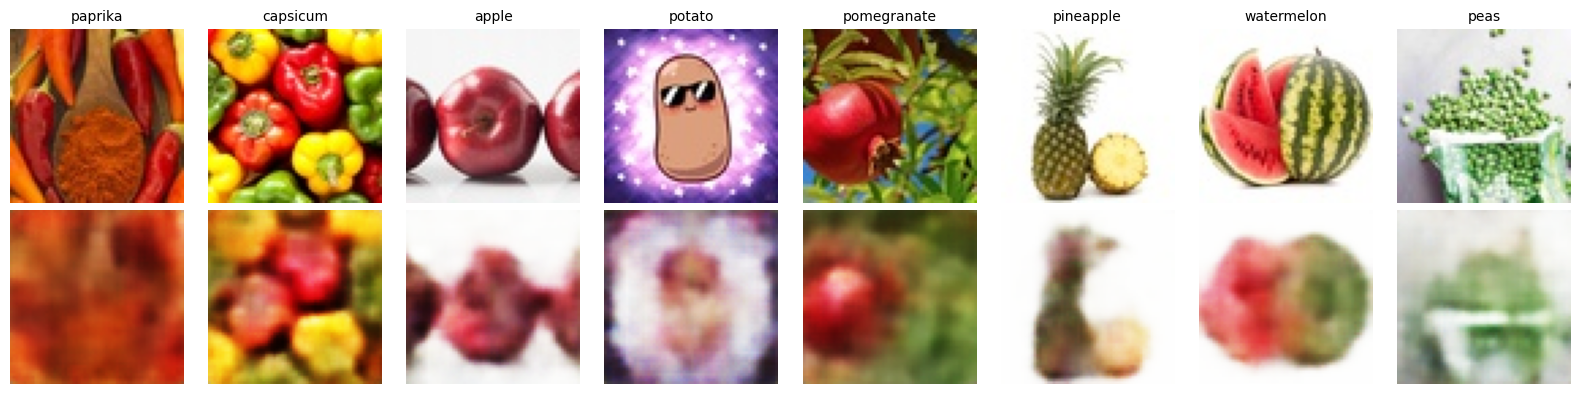

In [ ]:
# Create a dataloader for the validation set
val_dl = ImageDataLoader.create_dataloader(
    "./data/resized64/versions/8/validation", batch_size=8, shuffle=True, num_workers=4,
)

# get one batch from the dataloader
batch = next(iter(val_dl))
imgs, targets = batch[0], batch[1]

imgs = imgs.to(device)

with torch.no_grad():
    reconstructed_imgs, _, _, _ = vae(imgs)

# move tensors to cpu for visualization
reconstructed_imgs = reconstructed_imgs.cpu()
imgs_cpu = imgs.cpu()

# plot grid: 2 rows x 8 columns (first row: ground truth, second row: reconstructions)
n_cols = 8
fig, axs = plt.subplots(2, n_cols, figsize=(16, 4))
for col in range(n_cols):
    # original
    orig_pil = ToPILImage()(imgs_cpu[col])
    axs[0, col].imshow(orig_pil)
    axs[0, col].axis('off')
    # reconstructed
    recon_pil = ToPILImage()(reconstructed_imgs[col])
    axs[1, col].imshow(recon_pil)
    axs[1, col].axis('off')
    # label column by class (on the top subplot)
    cls_name = idx_to_class.get(int(targets[col]), '') if targets is not None else ''
    axs[0, col].set_title(cls_name, fontsize=10)

plt.tight_layout()
plt.show()

Note that the model itself is not aware of the categories in the dataset. Those are purely added for context in the visualization. It can be observed that the general visual structures of the images are captured well by the model, although the reconstructed images are smoothed and small details vanish. This is a common challenge with VAEs and is usually overcome using hierarchical latents (as, for example, in diffusion models). Particular to our choice of deconvolution in the decoder network is the grainy apprearance of the reconstructed samples. Smoother versions can be achieved using upsampling and standard convolution, but this proved to be way slower in our setup so we decided to stick to `ConvTranspose2d`.

## Latent and intermediate representation
In this section, we have a look into the feature maps of the encoder and decoder, and analize the latent representation.

In [38]:
# Utility class to capture intermediate activations from a model
from src.intermediate_activation_capture import IntermediateActivationCapture

capturer = IntermediateActivationCapture(vae)
results = capturer.capture_inference(imgs, device='cpu')

print(results["encoder_activations"]["encoder_conv4"].shape)

torch.Size([8, 256, 4, 4])


### Encoder Conv1

The first convolutional layer results in 32 feature maps of size 32*32. Let's visualize a couple. 

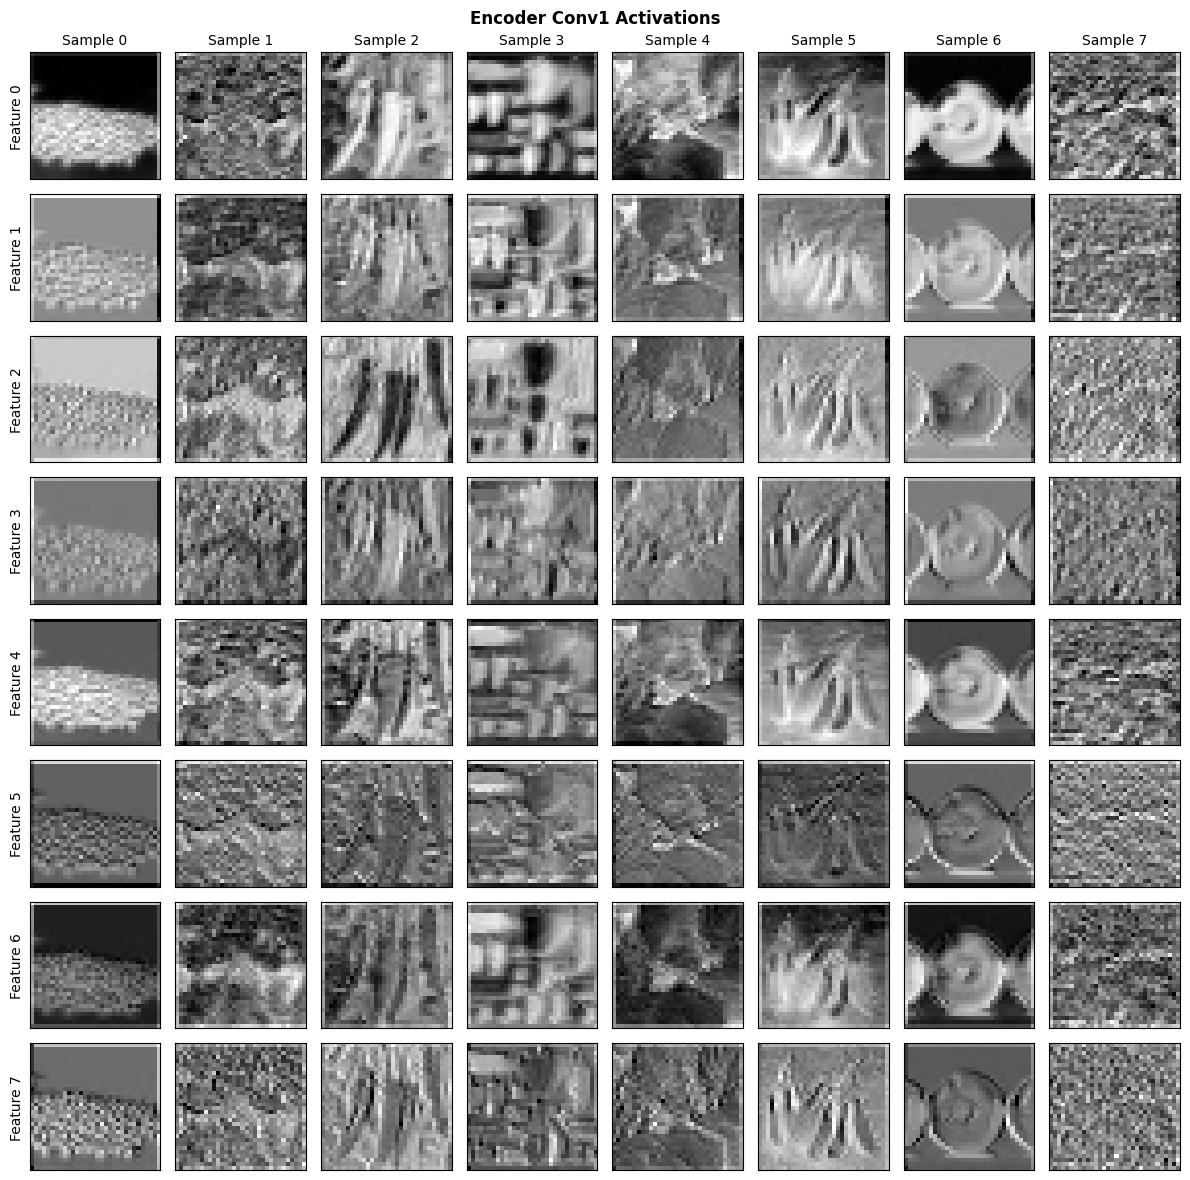

In [44]:
from src.utils import visualize_activation_maps

# Visualize first 8 feature maps
fig1 = visualize_activation_maps(results["encoder_activations"]["encoder_conv1"], n_maps=8, cmap='gray', title="Encoder Conv1 Activations")
plt.show()

### Encoder Conv2

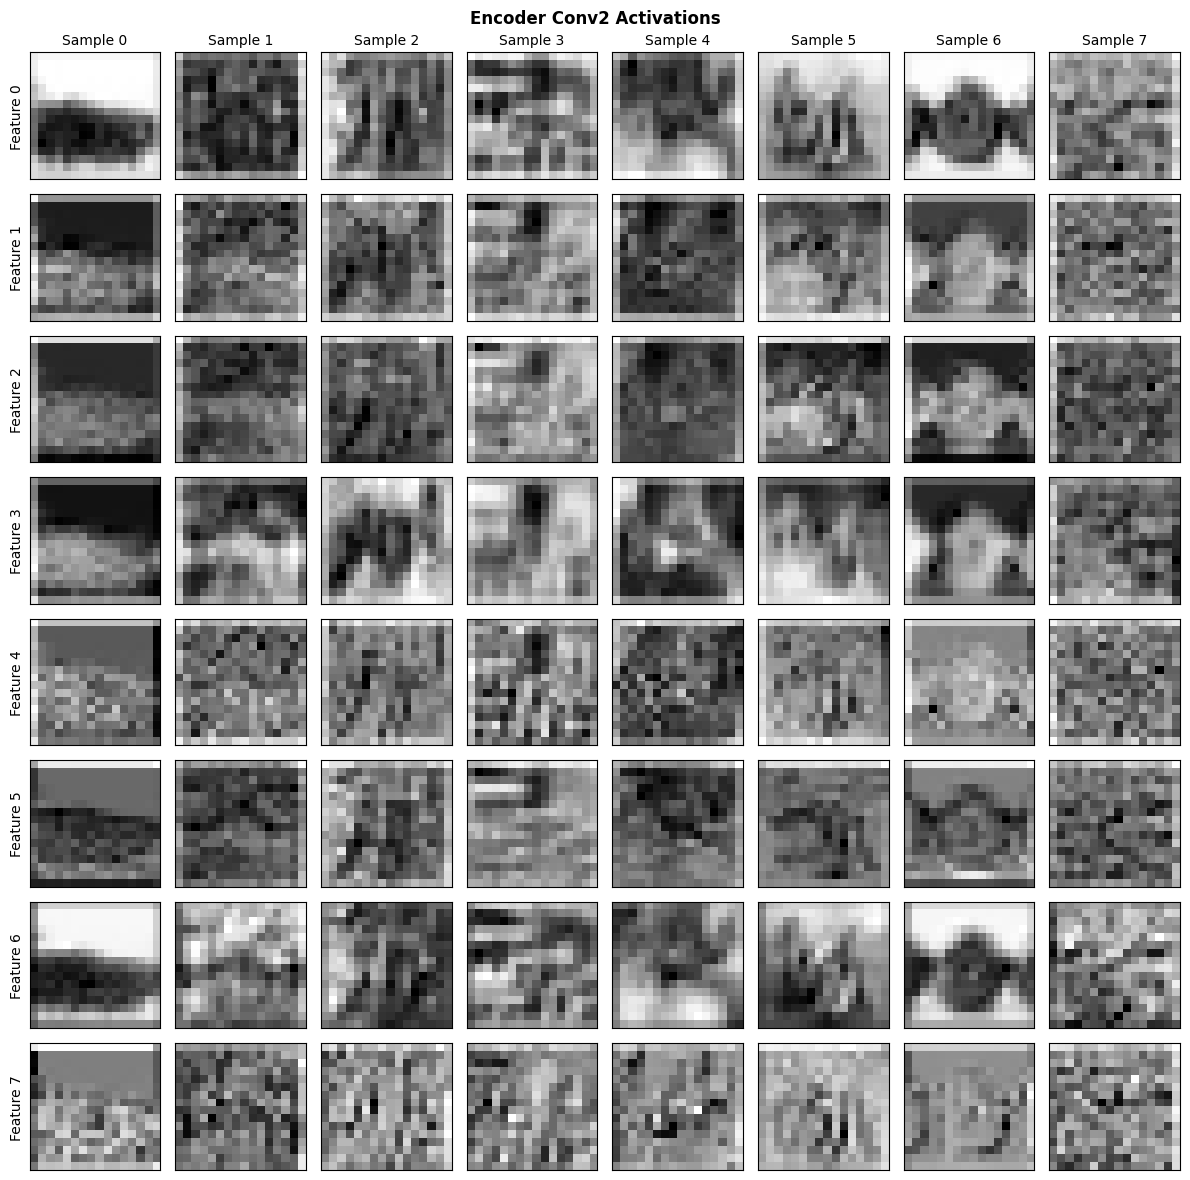

In [45]:
fig1 = visualize_activation_maps(results["encoder_activations"]["encoder_conv2"], n_maps=8, cmap='gray', title="Encoder Conv2 Activations")
plt.show()

### Encoder Conv3

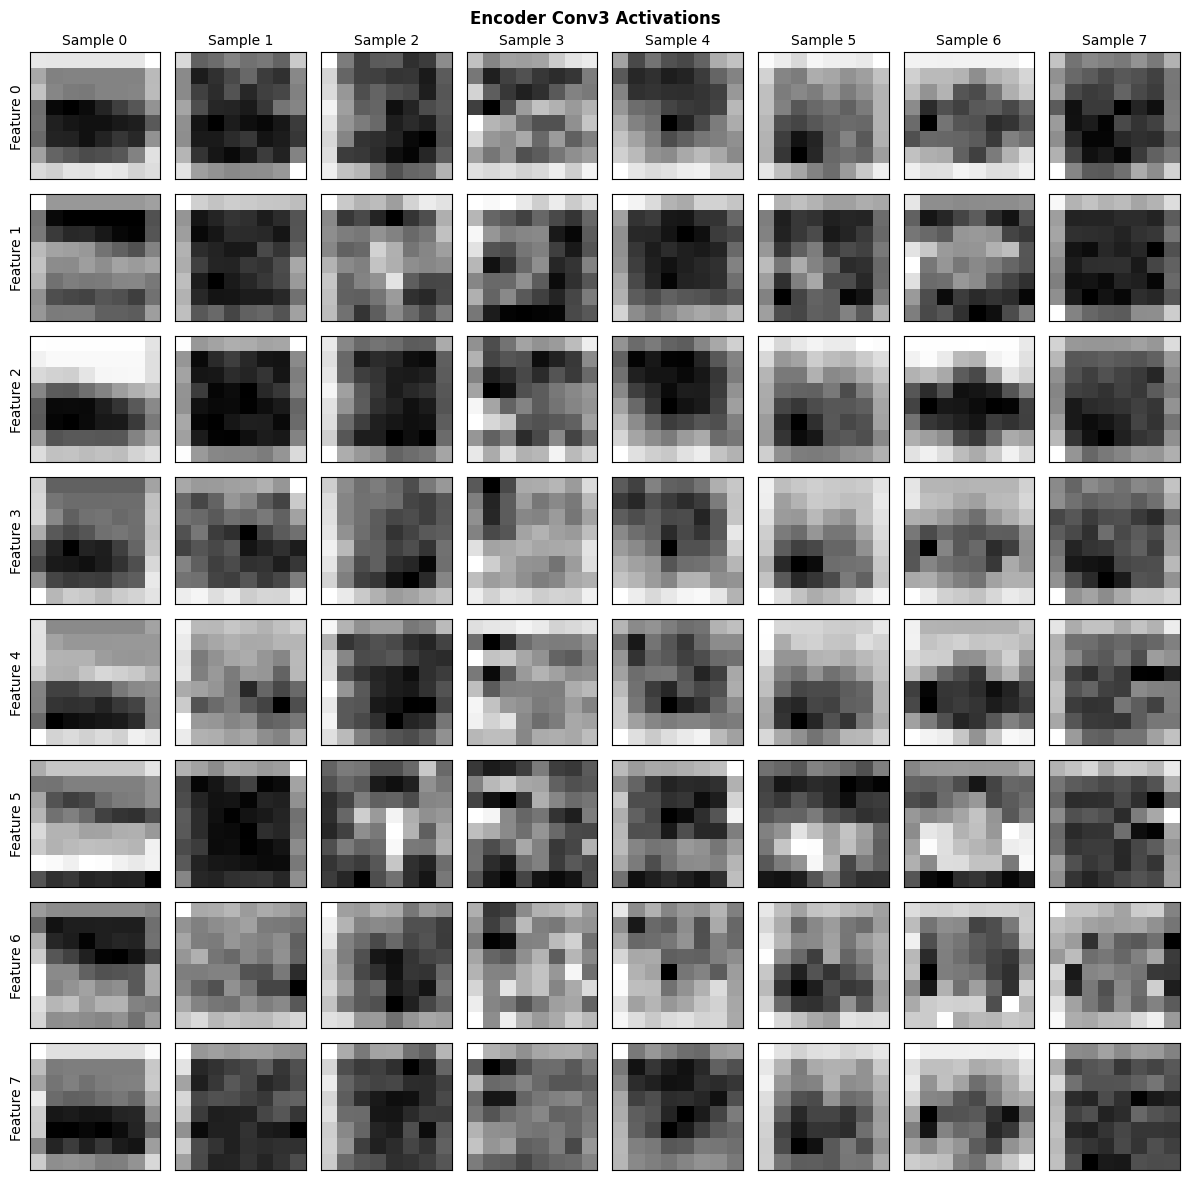

In [46]:
fig1 = visualize_activation_maps(results["encoder_activations"]["encoder_conv3"], n_maps=8, cmap='gray', title="Encoder Conv3 Activations")
plt.show()

### Encoder Conv4

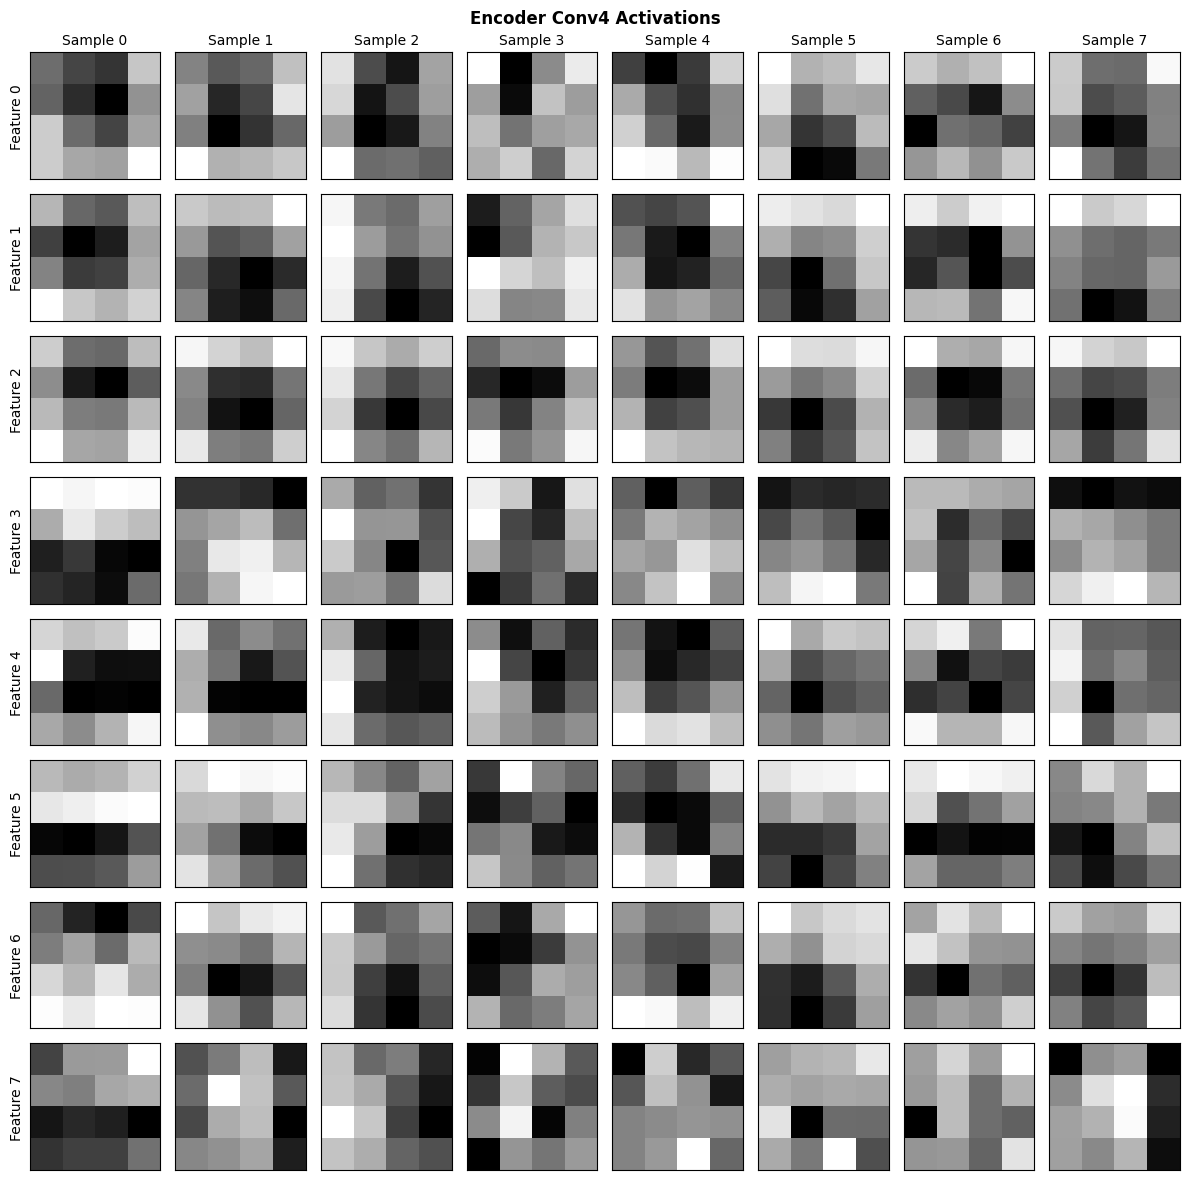

In [47]:
fig1 = visualize_activation_maps(results["encoder_activations"]["encoder_conv4"], n_maps=8, cmap='gray', title="Encoder Conv4 Activations")
plt.show()

### Latent representation z

Latent representations in the VAE are composed of mean and logvar variance vectors of the latent distribution. In our example, we plot the mean values to see if we spot any patterns in the activations.

We follow up with a class-based analysis later.

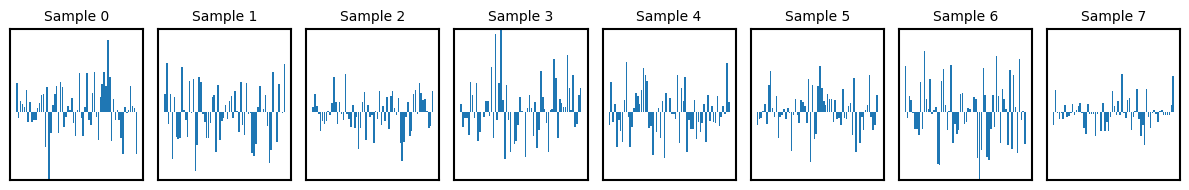

In [52]:
def plot_latent_vectors(z, figsize=None):
    z_np = z.detach().cpu().numpy() if isinstance(z, torch.Tensor) else z
    fig, axes = plt.subplots(1, z_np.shape[0], figsize=figsize or (z_np.shape[0]*1.5, 2))
    axes = [axes] if z_np.shape[0] == 1 else axes
    vmin, vmax = z_np.min(), z_np.max()
    for i, (ax, row) in enumerate(zip(axes, z_np)):
        ax.bar(range(z_np.shape[1]), row)
        ax.set_ylim(vmin, vmax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Sample {i}', fontsize=10)
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)
    plt.tight_layout()

plot_latent_vectors(results["encoder_activations"]["encoder_fc_mu"])

### Decoder Deconv1

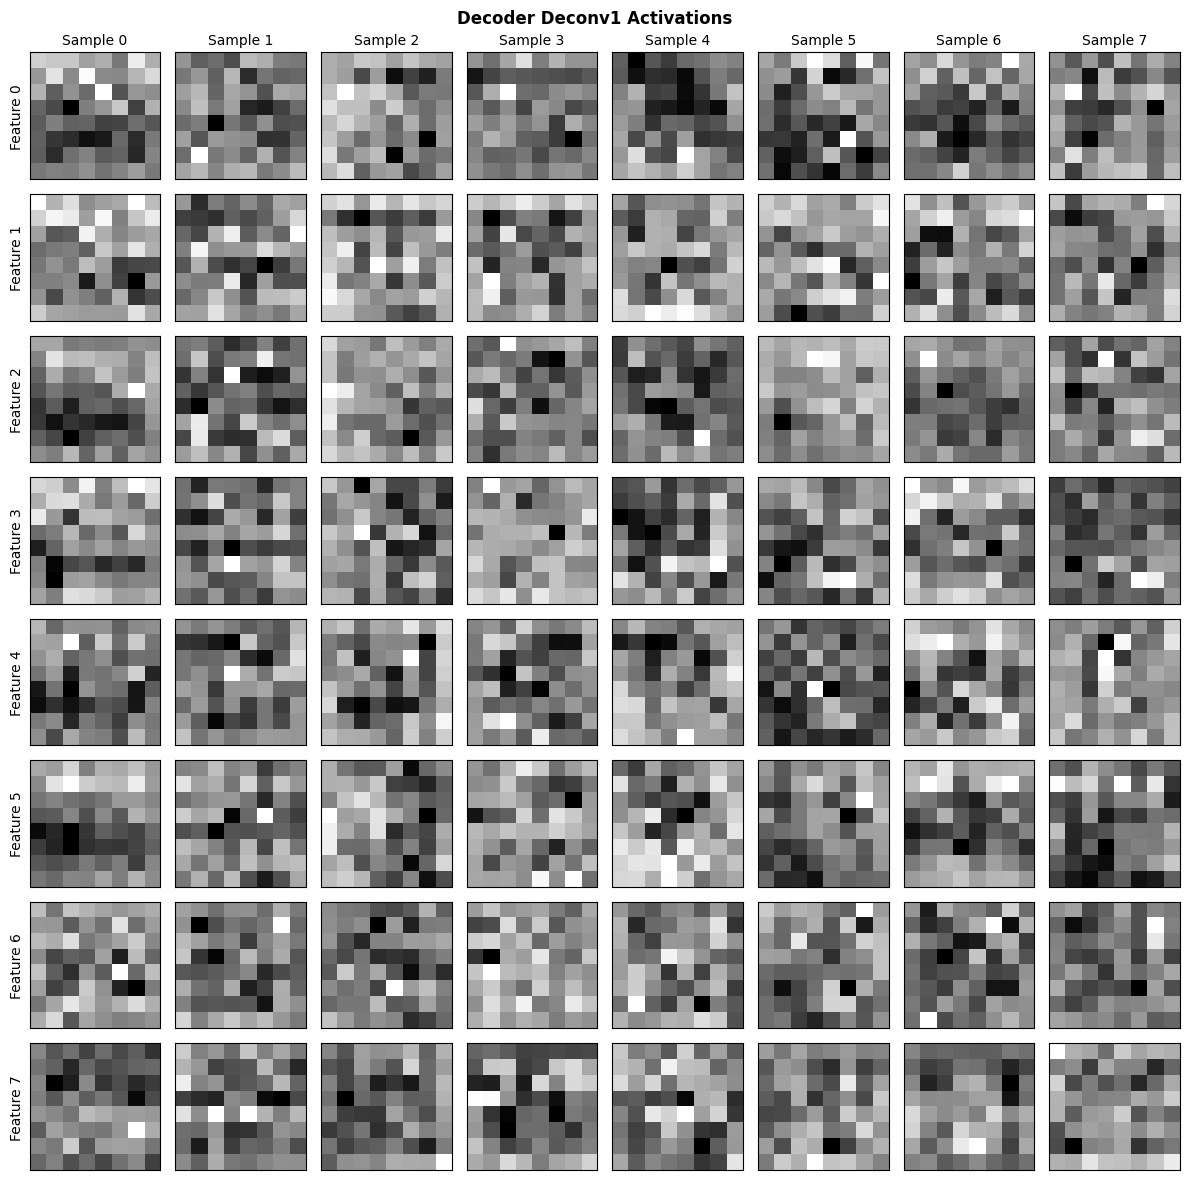

In [55]:

fig = visualize_activation_maps(results["decoder_activations"]["decoder_deconv1"], n_maps=8, cmap='gray', title="Decoder Deconv1 Activations")
plt.show()

### Decoder Deconv2

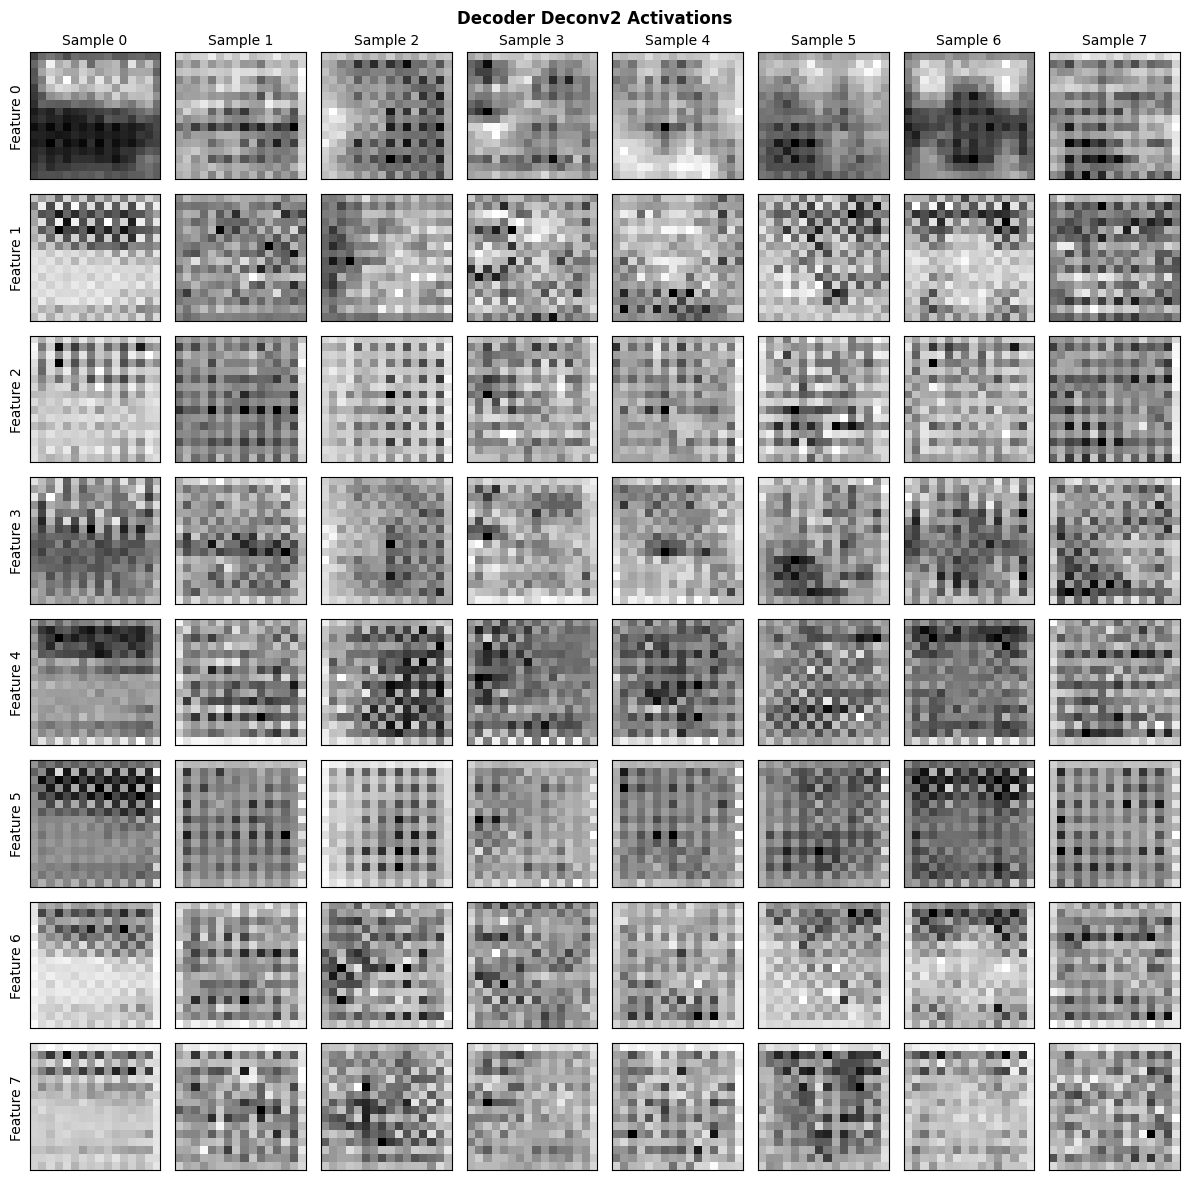

In [56]:
fig = visualize_activation_maps(results["decoder_activations"]["decoder_deconv2"], n_maps=8, cmap='gray', title="Decoder Deconv2 Activations")
plt.show()

### Decoder Deconv3

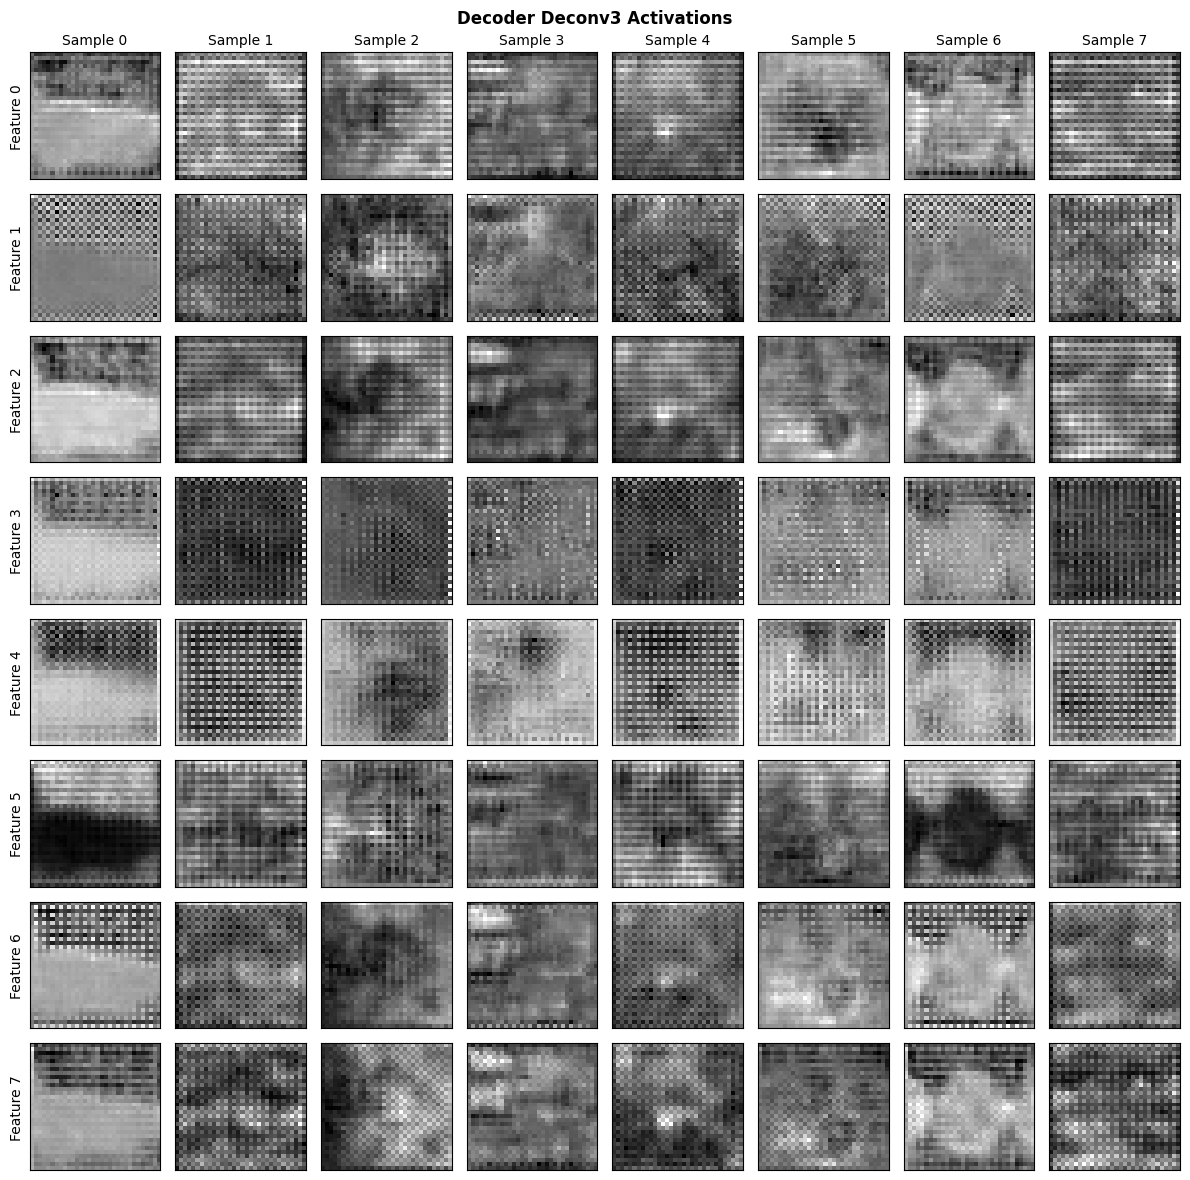

In [57]:
fig = visualize_activation_maps(results["decoder_activations"]["decoder_deconv3"], n_maps=8, cmap='gray', title="Decoder Deconv3 Activations")
plt.show()

### Decoder Deconv4
These correspond to the three color channels RGB of the reconstructed images.

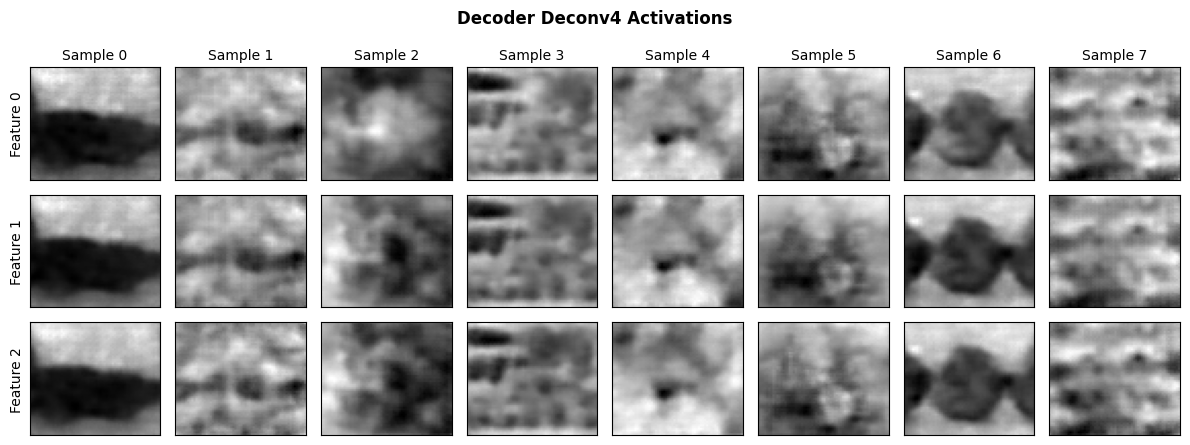

In [58]:
fig = visualize_activation_maps(results["decoder_activations"]["decoder_deconv4"], n_maps=8, cmap='gray', title="Decoder Deconv4 Activations")
plt.show()

## Generative abilities
We shall now investigate the generative abilities of our VAE. In theory, samples belonging to the data distribution can be obtained simply by passing samples from the latent prior (in our case a 64-dimensional isotropic unit Gaussian) through the decoder. In practice, model training is usually not stable enough to allow for interpretable results from this method. Instead, it is recommended to use the dataset (or data subset) mean latent as a prior. That being said, let's try to generate some apples by sampling from the mean apple latent distribution.

In [ ]:
# Create a dataloader for the training set (equivalent for validation/test sets)
val_dl = ImageDataLoader.create_dataloader(
    "./data/resized64/versions/8/validation", batch_size=8, shuffle=True, num_workers=4,
)

# get one batch from the dataloader
batch = next(iter(val_dl))
imgs, targets = batch[0], batch[1]

## Hand-picked examples
## Adversarial attacks
...